# Interactive tutorial: extracellular electrical stimulation

## Objectives:
- Gain an intuitive understanding of the impact of various features on neural excitability, namely: 
    - **current polarity and intensity**
    - **electrode-fiber relative positioning**
    - **fiber morphology**
    - **medium properties**
- Understand the concept of ***activating function*** as a predictor of neural excitability

To better understand these concepts, we will again turn to computational modeling, which consitutes an optimal tool to dissect biophysical interactions. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
import numpy as np
from ipywidgets import Layout, FloatSlider, FloatLogSlider
from fibermodel import MyelinatedFiber
from medium import VolumeConductor
from stimulus import ExtracellularCurrentPulseTrain
from neuronsims import Simulation, interactive_display
from logger import logger

## Basic model components

We will start by modeling the 3 components interacting in our system of interest, namely:
- **a spatially extended neuron model**
- **an electrically conducting extracellular medium**
- **an stimulation electrode** 

As you have seen during the course, the electrical excitability of neural structures depends on multiple factors such as neuronal morphology and the spatial distribution of the induced extracellular potential.

These interactions can be difficult to interpret if we consider the complex 3D $(x, y, z)$ morphology of brain neurons. Therefore, we will leverage here a simplified system, made of a **peripheral axon segment running on a straight line in a nerve**. The morphological and geometrical simplicity of this system allows us better understand stimulus-neuron interactions on a projected $(xz)$ plane, where $x$ is the direction of the fiber and $z$ is the perpendicular direction.

### Axon model

We are going to use a double-cable, multi-compartment model of a myelinated axon as defined in [McIntyre et al. 2002](https://doi.org/10.1152/jn.00353.2001). Because it incorporates a highly realistic morphology of the spatially distributed neural membrane, this so-called *MRG model* is a consolidated biophysical model used to study the excitability of myelinated axons by electrical fields.

Note that this model is parameterized as a function of axon diameter and number of nodes or Ranvier, such that it can be used to model myelinated axons or arbitrary diameters and lengths.

We will start by defining a "typical" axon of 10 μm diameter and comprising 101 nodes. This  corresponds to a axon length of about 11.5 centimeters, which is more than enough to study local interactions around the axon's mid-point with little to no "edge" effects.

In [3]:
diam = 20. # um
nnodes = 101 
fiber = MyelinatedFiber(diam, nnodes=nnodes)
logger.info(f'fiber is {fiber.length / 1e4:.2f} cm long')
fiber.get_details()

 22/02/2022 17:50:42: created MyelinatedFiber(20.0um, 101 nodes) model
 22/02/2022 17:50:42: fiber is 17.00 cm long


,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),xr (MOhm/cm),xg (S/cm2),xc (uF/cm2)
node,101,1,7.5,1.0,2.0,70.0,148505.012216,1.000000e+10,0.000000
MYSA,200,1,7.5,3.0,2.0,70.0,148505.012216,2.941176e-06,0.000294
FLUT,200,1,17.5,68.0,2.0,70.0,31823.714626,2.941176e-06,0.000294
STIN,600,1,17.5,259.5,2.0,70.0,31823.714626,2.941176e-06,0.000294


### Extracellular medium

To start with, we will model the extracellular medium as an isotropic volume conductor model with a conducivity mimicking that of grey matter (σ=2 S/m).

In [4]:
medium = VolumeConductor(sigma=2.)

 22/02/2022 17:50:42: created IsotropicVolumeConductor(sigma=[2. 2. 2.]S/m)


### Stimulus

We will consider the simple case of a point source electrode located 100 μm above the axon central node, injecting brief 100 μs pulses of cathodic current (-1 μA) in the extracellular medium.


In [5]:
stim = ExtracellularCurrentPulseTrain(
    pos=(0., 0., 100.),  # um
    I=-10.,  # uA
    tpulse=.1,  # ms
    npulses = 2,
    PRF = 0.2,  # kHz
    tstart=2. # ms
)

 22/02/2022 17:50:42: created ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)


Finally, we assemble all our model components into a simulation object:

In [6]:
sim = Simulation(fiber, medium, stim)

## Recall: the *activating function*

Throughout this tutorial, we will regularly refer to the concept of ***activating function*** in order to predict neural excitability under various conditions of extracellular electrical stimulation. As you have seen during the course, the activating function is defined as the *second spatial derivative of the extracellular potential along the neuron membrane*. In our simplified system, this relationship can be expressed as:

$$Ψ = \frac{d^2φ}{dx^2}$$

where $φ$ represents teh extracellular potential and $x$ is the axial position along the axon.

## Impact of stimulation polarity (cathodic vs anodic)

We will first investigate the impact of stimulation polarity on the excitability of our neuron model.

### Predictions
We will first have a look at how current polarity and intensity impact the activating function.

Output()

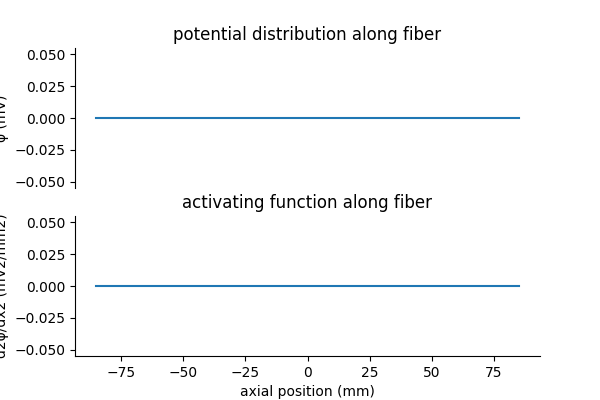

In [7]:
slider_layout = Layout(width='500px')
Irange = FloatSlider(
    description='I (uA)', min=-100, max=500, value=0, step=5, continuous_update=False, layout=slider_layout)

def update(I, **kwargs):
    sim.stim.I = I
    return sim.plot_profiles(**kwargs)

interactive_display(update, Irange);

#### Questions:

- *What is the nature of the extracellular potential profile along the axon?*
- *What is the nature of the activating function profile along the axon?*
- *How are those profiles affected by the current intensity and polarity?* 
- *Based on the profiles of the activating function, where do you expected the axon to be excited for cathodic stimuation ($I < 0$)? And for anodic stimulation ($I> 0$)?*
- *Based on these results, what type of stimulation (cathodic or anodic) will be more efficient?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 22/02/2022 17:50:43: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=0.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

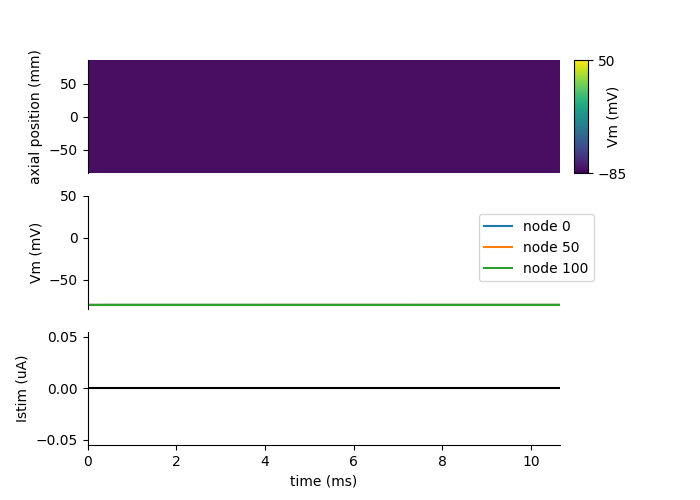

In [8]:
def update(I, **kwargs):
    sim.stim.I = I
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(update, Irange);

#### Questions:

- *What is the minimum current required to trigger an action potential with an **anodic** source? And with a **cathodic** source?*
- *At which locations is the axon initially excited with **cathodic** stimulation? And with **anodic** stimulation?*
- *How do these observations compare to predictions of the activating function?*

## Impact of pulse width

Now that we've established how and why cathodic stimulation is a the more efficient extracellular stimulation polarity, let's analyze the impact of the pulse width on neural excitability.

Because the pulse width is not directly related with the spatial features of our system, its impact cannot be predicted through the prism of the activating function. Hence we will simply run simulations of our system.  

 22/02/2022 17:50:44: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=0.00uA, tpulse=0.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

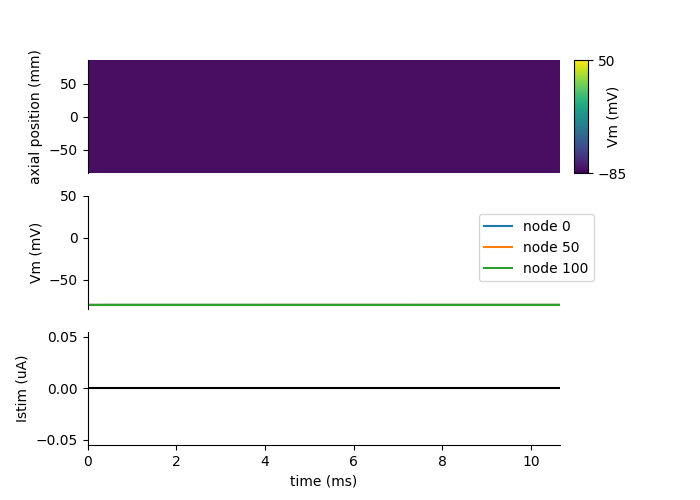

In [9]:
Irange.min = -300
Irange.max = 0.
Irange.step = 1.
PWrange = FloatLogSlider(
    description='PW (ms)', base=10, min=-2, max=1, value=0, step=0.2, continuous_update=False, layout=slider_layout)

def update(I, PW, **kwargs):
    sim.stim.I = I
    sim.stim.tpulse = PW
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(update, Irange, PWrange);

#### Questions:

- *Using a cathodic source, what is the excitation threshold current for pulses of a 10 μs long pulse? What about 100 μs, 1 ms, 10 ms?*
- *What can you say about the evolution of the threshold excitation current as a function of pulse width?*
- *Which theoretical concept does that illustrate?*

## Impact of electrode-axon distance

Beyond the temporal characteristics of the stimulus, neural excitability is obviously impacted by the geometrical arrangement between the current source (the electrode) and the neural target (the axon). We will analyze here the impact of electrode-axon distance on excitation thresholds. 

### Predictions
We will first have a look at electrode-neuron distance impacts the activating function.

Output()

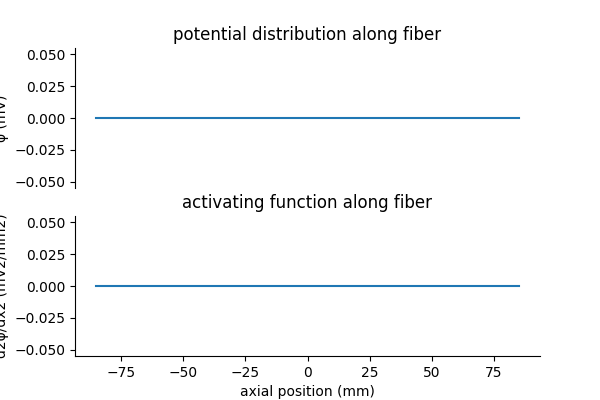

In [10]:
dzrange = FloatLogSlider(
    description='Δz (um)', base=10, min=0, max=4, value=1, step=0.2, continuous_update=False, layout=slider_layout)

def update(dz, **kwargs):
    sim.stim.pos = (0., 0., dz)
    return sim.plot_profiles(**kwargs)

interactive_display(update, dzrange);

#### Questions

- *How does electrode-axon distance impact the extracellular voltage profile along the axon?*
- *What about the impact on the activating function?*
- *Based on these results, do you expect excitation thresholds to increase or decrease as the electrode-axon distance increases?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 22/02/2022 17:50:45: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=0.00uA, tpulse=0.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

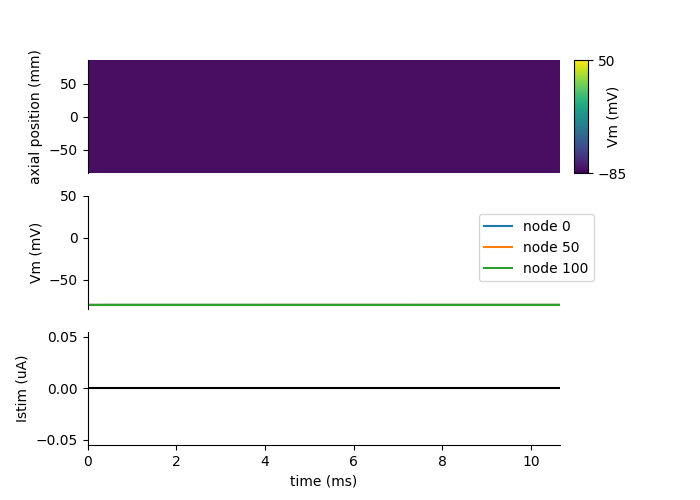

In [11]:
def update(I, dz, **kwargs):
    sim.stim.I = I
    sim.stim.pos = (0., 0., dz)
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(update, Irange, dzrange);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for an electrode located 10 μm away from the axon? What about 100 μm, 1mm?*
- *What can you say about the evolution of the threshold excitation current as a function of electrode-axon distance?*
- *How do these observations compare to predictions of the activating function?*

## Impact of medium conductivity

Beyond the geometrical arrangement, ...

### Predictions
We will first have a look at how medium conductivity impacts the activating function.

Output()

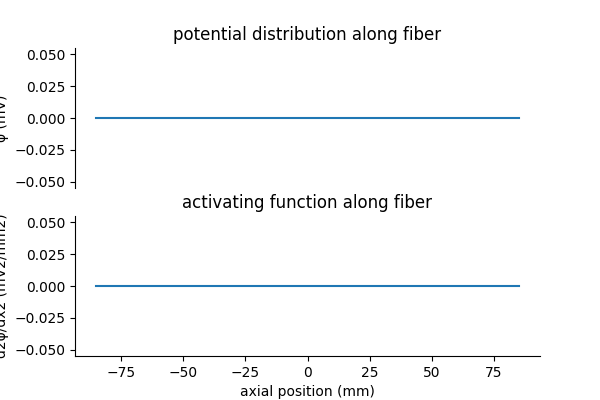

In [12]:
sigmax_range = FloatSlider(
    description='σ_x (S/m)', min=1, max=10, value=3, step=0.5, continuous_update=False, layout=slider_layout)

def update(I, sigmax, **kwargs):
    sim.stim.I = I
    sigma = sim.medium.sigma
    sim.medium.sigma = (sigmax, sigma[1], sigma[2])
    return sim.plot_profiles(**kwargs)

interactive_display(update, Irange, sigmax_range);

#### Questions

- *What is the impact of medium conductivity on the profile of extracellular voltage along the axon?*
- *What about its impact on the activating function?*
- *Based on these results, do you expect excitation thresholds to increase or decrease as the medium conductivity along the axon increases?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 22/02/2022 17:50:47: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=0.00uA, tpulse=0.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

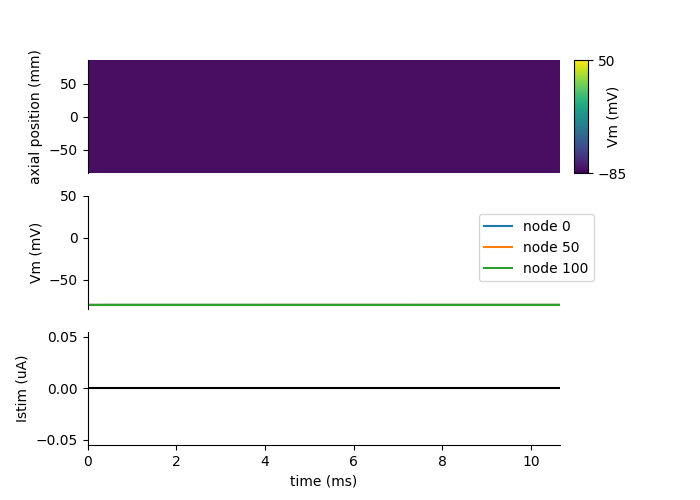

In [13]:
def update(I, sigmax, **kwargs):
    sim.stim.I = I
    sigma = sim.medium.sigma
    sim.medium.sigma = (sigmax, sigma[1], sigma[2])
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(update, Irange, sigmax_range);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for a medium conductivity of 1 S/m? What about 10 S/m?*
- *What can you say about the evolution of the threshold excitation current as a function of medium conductivity?*
- *How do these observations compare to predictions of the activating function?*

## Impact of morphology

Beyond stimulus parameters, electrode-neuron relative positioning and medium properties, we also know from empirical observations that neuronal morphology (i.e. the structure and spatial distribution of the different parts of a neuron) greatly impacts excitability by electrical fields.

In our simplified system, we can analyze this impact by varying the axon outer diameter and assessing the resulting changes on excitation thresholds.

 22/02/2022 17:50:48: created MyelinatedFiber(10.0um, 101 nodes) model
 22/02/2022 17:50:48: simulating MyelinatedFiber(10.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=0.00uA, tpulse=0.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

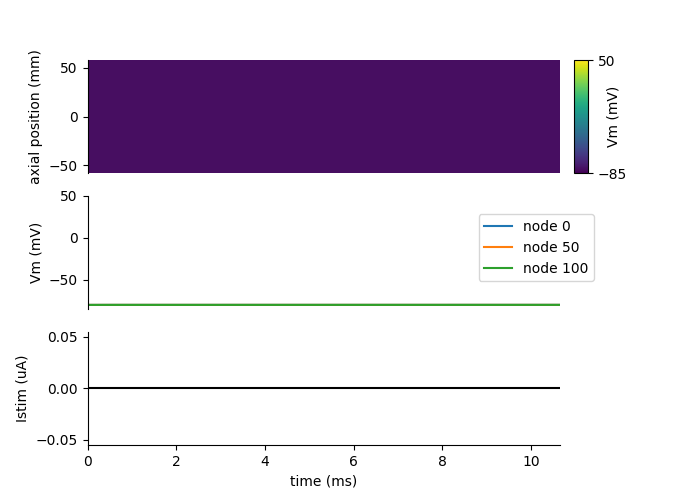

In [14]:
drange = FloatSlider(
    description='diam (μm)', min=3, max=20, value=10, step=1, continuous_update=False, layout=slider_layout)

def update(I, d, **kwargs):
    sim.stim.I = I
    sim.fiber = MyelinatedFiber(d, nnodes=nnodes)
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(update, Irange, drange);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for an 5 μm-wide axon? What about 10 μm, 20 μm?*
- *What can you say about the evolution of the threshold excitation current as a function of axon outer diameter?*
- *How does this trend compare to the natural recruitment order of neural fibers?*

## Conclusions

This tutorial should have given you a good intuition of the impact of the following features on neural excitability:
- **current polarity and intensity**
- **electrode-fiber relative positioning**
- **fiber morphology**
- **medium properties**